In [38]:
import os
import sys
import optuna


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from simulator.utils.load_data import load_md_from_file
from simulator.utils.get_info import get_pnl
from simulator.strategies.stoikov_avellaneda import StoikovAvellaneda
from simulator.strategies.symetrical import Symetrical
from simulator.simulator import Sim
from simulator.strategies.limit_market import LimitMarketStrategy

PATH_TO_FILE = '../md/btcusdt_Binance_LinearPerpetual/'
NROWS = 1_000_000

md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)
# delay between orders
delay = pd.Timedelta(0.1, 's').delta

hold_time = pd.Timedelta(10, 's').delta


# strategy = Symetrical(delay, hold_time)
# strategy = StoikovAvellaneda(delay, hold_time, gamma=0.5, sigma=0.05,
#                              k=0.5, time_trading_session_ends=1655976252045000000)


C:\Users\igorl\AppData\Local\Temp\ipykernel_11660\447944604.py:24: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  latency = pd.Timedelta(10, 'ms').delta
C:\Users\igorl\AppData\Local\Temp\ipykernel_11660\447944604.py:25: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  md_latency = pd.Timedelta(10, 'ms').delta
C:\Users\igorl\AppData\Local\Temp\ipykernel_11660\447944604.py:29: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  delay = pd.Timedelta(0.1, 's').delta
C:\Users\igorl\AppData\Local\Temp\ipykernel_11660\447944604.py:31: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  hold_time = pd.Timedelta(10, 's').delta


parab_k1 < 0 точно 
parab_k2 < 0 не сильно 
parab_k1 > 0 точно 

In [41]:
def objective(trial):
    sim = Sim(md, latency, md_latency)

    line_coefficient_1 = trial.suggest_float('k_1', 0, 10)
    line_coefficient_2 = trial.suggest_float('k_2', 0, 10)
    parab_k1 = trial.suggest_float('par_k_1', -5, 0)
    parab_k2 = trial.suggest_float('par_k_2', -20, 0)
    parab_k3 = trial.suggest_float('par_k_3', 0, 20)
    

    strategy = LimitMarketStrategy(
        line_coefficients=(line_coefficient_1, line_coefficient_2),
        parabola_coefficients=(parab_k1, parab_k2, parab_k3)
    )

    trades_list, md_list, updates_list, all_orders = strategy.run(sim)
    df = get_pnl(updates_list)

    return -df.total.values[-1]/df.total.diff().std()


In [42]:
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

study.best_params

[I 2022-11-16 21:04:06,241] A new study created in memory with name: no-name-4e321e22-30f0-4650-a73b-2125a99e6d0f
[I 2022-11-16 21:04:48,536] Trial 0 finished with value: -803.0651121744102 and parameters: {'k_1': 7.885729933978861, 'k_2': 0.9292063835571862, 'par_k_1': -4.860503045007142, 'par_k_2': -15.005046009873439, 'par_k_3': 4.482495036087057}. Best is trial 0 with value: -803.0651121744102.
[I 2022-11-16 21:05:30,486] Trial 1 finished with value: -2394.1152597022647 and parameters: {'k_1': 2.069833975334449, 'k_2': 0.9857139803900095, 'par_k_1': -1.397716771551663, 'par_k_2': -4.50877158628964, 'par_k_3': 4.596957460757592}. Best is trial 1 with value: -2394.1152597022647.
[I 2022-11-16 21:06:12,519] Trial 2 finished with value: -3836.591048312306 and parameters: {'k_1': 2.359904782042861, 'k_2': 5.8312123532119955, 'par_k_1': -4.671935978513916, 'par_k_2': -2.3266732984681298, 'par_k_3': 10.882487211841799}. Best is trial 2 with value: -3836.591048312306.
[I 2022-11-16 21:06:5

{'k_1': 4.9540042694748925,
 'k_2': 1.5822144350998517,
 'par_k_1': -8.767594502889673e-05,
 'par_k_2': -0.004150558361358119,
 'par_k_3': 13.739252375746702}

In [45]:
study.best_params

{'k_1': 4.9540042694748925,
 'k_2': 1.5822144350998517,
 'par_k_1': -8.767594502889673e-05,
 'par_k_2': -0.004150558361358119,
 'par_k_3': 13.739252375746702}

{'gamma': 0.04069983912543654,
 'sigma': 0.028574677266288373,
 'k': 0.031706478400614996} - for Stoikov avelanida

In [46]:

# Trial 71 finished with value: -94139342.21393743 and parameters: {'gamma': 0.0875180040071227, 'sigma': 0.11382020799722299, 'k': 0.012697625777652544}. Best is trial 71 with value: -94139342.21393743.

In [47]:
strategy = LimitMarketStrategy(
    line_coefficients=(4.9540042694748925, 1.5822144350998517),
    parabola_coefficients=(-8.767594502889673e-05, -
                           0.004150558361358119, 13.739252375746702)
)

trades_list, md_list, updates_list, all_orders = strategy.run(sim)
df = get_pnl(updates_list)

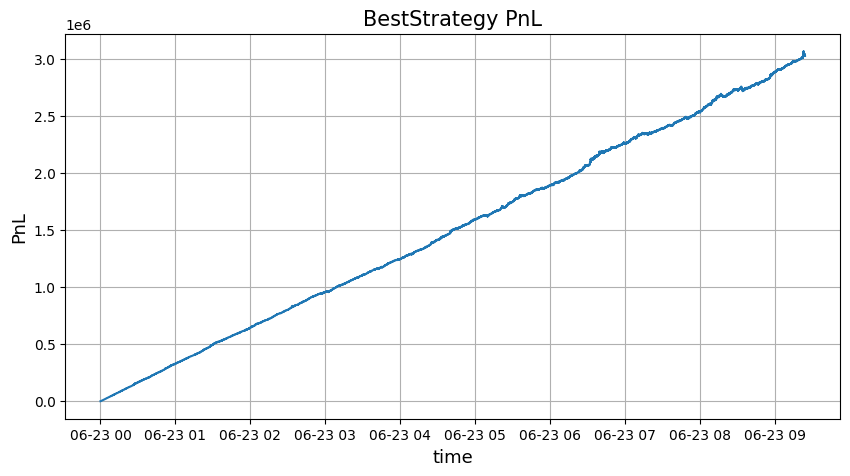

In [49]:
dt = pd.to_datetime(df.receive_ts)
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("BestStrategy PnL", fontsize=15)
plt.grid()
plt.show()

In [51]:
md = load_md_from_file(path=PATH_TO_FILE, nrows=100000000000)

In [52]:
sim = Sim(md, latency, md_latency)

strategy = LimitMarketStrategy(
    line_coefficients=(4.9540042694748925, 1.5822144350998517),
    parabola_coefficients=(-8.767594502889673e-05, -
                           0.004150558361358119, 13.739252375746702)
)

trades_list, md_list, updates_list, all_orders = strategy.run(sim)
df = get_pnl(updates_list)

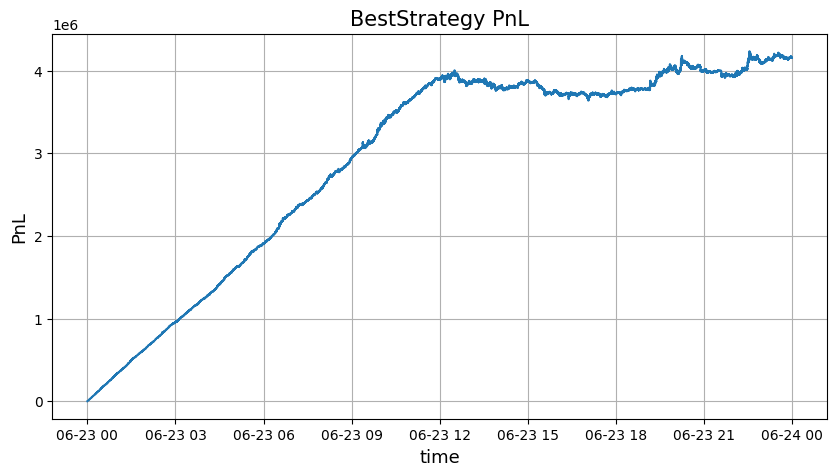

In [56]:
dt = pd.to_datetime(df.receive_ts)
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("BestStrategy PnL", fontsize=15)
plt.grid()
plt.show()